In [22]:
import torch
from torch.utils.data import Dataset
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection import ssd300_vgg16

import torchvision

import torch.optim as optim
from tqdm import tqdm

In [23]:
class BCCDDatasetVOC(Dataset):
    def __init__(self, root_dir, image_set='train', transform=None):
        self.root_dir = root_dir
        self.image_set = image_set
        self.transform = transform
        
        with open(os.path.join(root_dir, 'ImageSets', 'Main', f'{image_set}.txt')) as f:
            self.image_ids = [line.strip() for line in f.readlines()]

        self.img_dir = os.path.join(root_dir, 'JPEGImages')
        self.anno_dir = os.path.join(root_dir, 'Annotations')

        self.class_to_idx = {'RBC':0, 'WBC':1, 'Platelets':2}

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]

        img_path = os.path.join(self.img_dir, f'{img_id}.jpg')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        anno_path = os.path.join(self.anno_dir, f'{img_id}.xml')
        tree = ET.parse(anno_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall('object'):
            name = obj.find('name').text
            labels.append(self.class_to_idx[name])

            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = np.array(boxes, dtype=np.float32)
        labels = np.array(labels, dtype=np.int64)

        target = {'boxes': boxes, 'labels': labels}

        if self.transform:
            img, target = self.transform(img, target)

        img = torch.from_numpy(img).permute(2,0,1).float() / 255.0

        return img, target

{'boxes': array([[156., 112., 256., 206.],
       [168., 374., 270., 477.],
       [238., 228., 320., 284.],
       [456., 161., 564., 251.],
       [537., 299., 640., 414.],
       [ 61.,  63., 185., 145.],
       [  7., 420., 107., 480.],
       [ 38., 129.,  87., 179.],
       [281., 182., 326., 225.],
       [585., 419., 624., 456.],
       [507., 340., 547., 377.],
       [ 15., 181., 209., 362.]], dtype=float32), 'labels': array([0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1])}


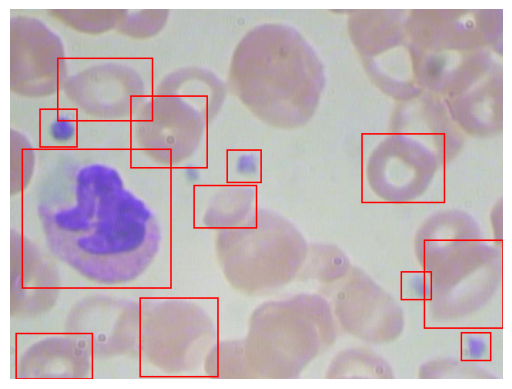

In [24]:
dataset = BCCDDatasetVOC(root_dir='C:/Projects/vsCode/ML_netol/ml_netologiya', image_set='train')

loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

imgs, targets = next(iter(loader))
print(targets[0])

img_example = (imgs[0] * 255).byte()
img_with_boxes = draw_bounding_boxes(img_example, boxes=torch.tensor(targets[0]['boxes']), width=2, colors='red')
plt.imshow(img_with_boxes.permute(1,2,0).numpy())
plt.axis('off')
plt.show()

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = ssd300_vgg16(weights=None, num_classes=4)

model.to(device)

cuda


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [39]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

num_epochs = 10
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, targets in tqdm(loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images = [image.to(device) for image in images]
        
        formatted_targets = []
        for t in targets:
            boxes = np.array(t['boxes'])
            labels = np.array(t['labels'])
            
            if boxes.size == 0:
                valid_boxes = torch.empty((0, 4), dtype=torch.float32, device=device)
                valid_labels = torch.empty((0,), dtype=torch.int64, device=device)
            else:
                valid_indices = np.where((boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1]))[0]
                valid_boxes = torch.tensor(boxes[valid_indices], dtype=torch.float32, device=device)
                valid_labels = torch.tensor(labels[valid_indices], dtype=torch.int64, device=device)
            
            formatted_targets.append({
                'boxes': valid_boxes,
                'labels': valid_labels
            })
        
        loss_dict = model(images, formatted_targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        running_loss += losses.item()
    
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(loader):.4f}')

Epoch 1/10: 100%|██████████| 52/52 [00:03<00:00, 15.63it/s]


Epoch 1, Loss: 5.9850


Epoch 2/10: 100%|██████████| 52/52 [00:03<00:00, 15.98it/s]


Epoch 2, Loss: 3.6431


Epoch 3/10: 100%|██████████| 52/52 [00:03<00:00, 15.86it/s]


Epoch 3, Loss: 3.3580


Epoch 4/10: 100%|██████████| 52/52 [00:03<00:00, 16.18it/s]


Epoch 4, Loss: 3.1063


Epoch 5/10: 100%|██████████| 52/52 [00:03<00:00, 16.38it/s]


Epoch 5, Loss: 2.9932


Epoch 6/10: 100%|██████████| 52/52 [00:03<00:00, 16.58it/s]


Epoch 6, Loss: 2.9376


Epoch 7/10: 100%|██████████| 52/52 [00:03<00:00, 16.16it/s]


Epoch 7, Loss: 2.9025


Epoch 8/10: 100%|██████████| 52/52 [00:03<00:00, 16.12it/s]


Epoch 8, Loss: 2.9309


Epoch 9/10: 100%|██████████| 52/52 [00:03<00:00, 15.95it/s]


Epoch 9, Loss: 2.8366


Epoch 10/10: 100%|██████████| 52/52 [00:03<00:00, 16.06it/s]

Epoch 10, Loss: 2.9588


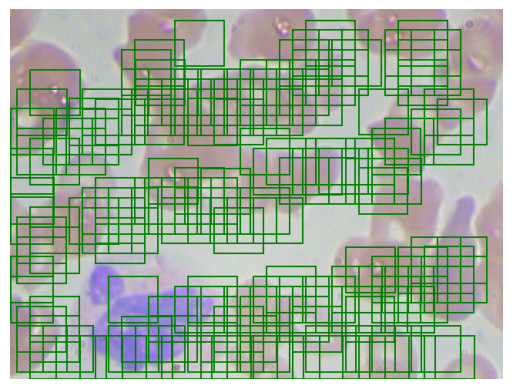

In [40]:
model.eval()

img, _ = dataset[0]
with torch.no_grad():
    pred = model([img.to(device)])

boxes = pred[0]['boxes'].cpu().numpy()
scores = pred[0]['scores'].cpu().numpy()
labels = pred[0]['labels'].cpu().numpy()

threshold = 0.5
selected = scores >= threshold
boxes = boxes[selected]
labels = labels[selected]

img_vis = (img * 255).byte()
img_with_boxes = draw_bounding_boxes(img_vis, boxes=torch.tensor(boxes), width=2, colors='green')
plt.imshow(img_with_boxes.permute(1,2,0).numpy())
plt.axis('off')
plt.show()